In [ ]:
# 📦 Install all required libraries
!pip uninstall -y whisper
!pip install -q git+https://github.com/openai/whisper.git
!pip install -q keras opencv-python librosa scikit-learn moviepy transformers
!sudo apt update && sudo apt install -y ffmpeg
!wget -q https://github.com/oarriaga/face_classification/raw/master/trained_models/emotion_models/fer2013_mini_XCEPTION.102-0.66.hdf5 -O emotion_model.h5

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.9 MB/s eta

📤 Upload an image (JPG/PNG) and an audio (MP3/MP4/WAV):


  warnings.warn("FP16 is not supported on CPU; using FP32 instead")



Saving cry.mp3 to cry.mp3
Saving anger.jpg to anger.jpg


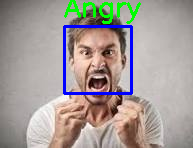


🎯 FINAL RESULTS
---------------------------
Facial Emotion   : Angry
Audio Emotion    : sad
Language         : en
Transcript       :  I'm sorry. I'm sorry. I'm sorry. I'm sorry.


In [ ]:
import whisper
import librosa
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from moviepy.editor import AudioFileClip
import cv2
from keras.models import load_model
from google.colab import files
from google.colab.patches import cv2_imshow

# === Load Models ===
speech_model = whisper.load_model("base")
face_model = load_model("emotion_model.h5", compile=False)
face_emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# === Text Emotion Classifier (Optional, if you want to add later) ===
#from transformers import pipeline
#text_emotion_model = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", top_k=1)

# === Train Simple Emotion Classifier for Audio ===
def train_emotion_classifier():
    X = np.random.rand(100, 26)  # 13 MFCC + 13 pitch
    y = np.random.choice(['happy', 'sad', 'angry', 'neutral'], size=100)
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    clf = SVC(kernel='linear')
    clf.fit(X, y_encoded)
    return clf, le

emotion_classifier, label_encoder = train_emotion_classifier()

# === Audio Feature Extraction ===
def extract_audio_features(audio_path):
    y, sr = librosa.load(audio_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    pitch, _ = librosa.core.piptrack(y=y, sr=sr)
    pitch = np.mean(pitch, axis=1)
    mfcc_features = np.mean(mfcc, axis=1)
    pitch_features = pitch[:13]
    features = np.concatenate([mfcc_features, pitch_features])
    return features

# === Audio Processing Pipeline ===
def process_audio(mp4_path):
    wav_path = "/content/temp_audio.wav"
    AudioFileClip(mp4_path).write_audiofile(wav_path, codec='pcm_s16le', verbose=False, logger=None)
    result = speech_model.transcribe(wav_path)
    text = result["text"]
    lang = result["language"]
    features = extract_audio_features(wav_path)
    emotion = classify_emotion(features)
    return text, lang, emotion

def classify_emotion(features):
    emotion_idx = emotion_classifier.predict([features])[0]
    return label_encoder.inverse_transform([emotion_idx])[0]

# === Facial Emotion Processing ===
def process_image(filename):
    img = cv2.imread(filename)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    detected = "No face detected"
    for (x, y, w, h) in faces:
        roi = gray[y:y+h, x:x+w]
        roi = cv2.resize(roi, (64, 64))
        roi = roi.astype("float32") / 255.0
        roi = np.expand_dims(roi, axis=-1)
        roi = np.expand_dims(roi, axis=0)
        pred = face_model.predict(roi, verbose=0)
        detected = face_emotion_labels[np.argmax(pred)]
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(img, detected, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    cv2_imshow(img)
    return detected

# === Upload and Process ===
print("📤 Upload an image (JPG/PNG) and an audio (MP3/MP4/WAV):")
uploaded = files.upload()

image_emotion = "Not uploaded"
audio_emotion = "Not uploaded"
transcript = ""
lang = ""

for fname in uploaded:
    if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
        image_emotion = process_image(fname)

    elif fname.lower().endswith(('.mp3', '.wav', '.mp4', '.m4a')):
        transcript, lang, audio_emotion = process_audio(fname)

# === Final Output ===
print("\n🎯 FINAL RESULTS")
print("---------------------------")
print(f"Facial Emotion   : {image_emotion}")
print(f"Audio Emotion    : {audio_emotion}")
print(f"Language         : {lang}")
print(f"Transcript       : {transcript}")